In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

## Transferring Data

We need to transfer the data on the device. In PyCUDA, mostly the data is transferred from `numpy` arrays on the host.

In [2]:
import numpy as np

a = np.random.randn(4, 4)

As, Numpy contains `Double` Precision Numbers, and most `NVIDIA` Devices support `single` precision numbers, so convert it:

In [3]:
a = a.astype(np.float32)

In [4]:
# To transfer data, allocate memory on the device
a_gpu = cuda.mem_alloc(a.nbytes)

In [5]:
# Now, transfer it
cuda.memcpy_htod(a_gpu, a)

## Executing a Kernel

Write CUDA C code and feed it into the constructor of a `pycuda.compiler.SourceModule`

In [7]:
mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)

<ipython-input-7-c451946613f0>:1: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  mod = SourceModule("""


If there aren't any errors, the code is now compiled and loaded onto the device. We find a reference to our `pycuda.driver.Function` and call it, specifying a_gpu as the argument, and a block size of 4x4:

In [8]:
func = mod.get_function('doublify')
func(a_gpu, block=(4, 4, 1))

In [9]:
func

In [12]:
# Fetch data back from GPU and display it
a_doubled = np.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

print(a_doubled)
print('a: ', a)

[[-1.0842828   0.5393581  -3.1617935  -1.1432903 ]
 [ 1.551553    0.2810028  -3.4556837  -0.8607264 ]
 [ 1.018071   -3.3495486   4.0959535   1.0568169 ]
 [ 0.19709903  1.3973002   0.2128194  -0.8326622 ]]
a:  [[-0.5421414   0.26967904 -1.5808967  -0.57164514]
 [ 0.7757765   0.1405014  -1.7278419  -0.4303632 ]
 [ 0.5090355  -1.6747743   2.0479767   0.52840847]
 [ 0.09854952  0.6986501   0.1064097  -0.4163311 ]]


### Shortcuts for Explicit Memory Copies

The `pycuda.driver.In`, `pycuda.driver.Out` and `pycuda.driver.InOut` args handler can simplify some of the memory transfers. For example, instead of creating <i>a_gpu</i>.

In [13]:
func(cuda.InOut(a), block=(4, 4, 1))

## Prepared Invocations

Function invocation using the built-in `pycuda.driver.Function.__call__()` method incurs overhead for type identification. To achieve the same effect as above without this overhead, the function is bound to argument types and then `called`. This also avoids having to assign explicit argument sizes using the `np.number` classes:

In [14]:
grid = (1, 1)
block = (4, 4, 1)
func.prepare("P")
func.prepared_call(grid, block, a_gpu)

### Abstracting Away the Complications

Using a `pycuda.gpuarray.GPUArray`, the same effect can be achieved with much less effort

In [15]:
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np

a_gpu = gpuarray.to_gpu(np.random.randn(4, 4).astype(np.float32))
a_doubled = (2 * a_gpu).get()

print(a_doubled)
print("a_gpu: ", a_gpu)

[[-0.08945474 -0.5400281  -0.01752748  0.78110343]
 [-0.5052433  -1.7441916  -3.313377    0.40380648]
 [-1.3185186   0.94914645  1.5345615   1.0412303 ]
 [-3.278224   -2.8810027  -2.5271356  -3.8058286 ]]
a_gpu:  [[-0.04472737 -0.27001405 -0.00876374  0.39055172]
 [-0.25262165 -0.8720958  -1.6566885   0.20190324]
 [-0.6592593   0.47457322  0.76728076  0.52061516]
 [-1.639112   -1.4405013  -1.2635678  -1.9029143 ]]


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\pycuda\elementwise.py:45: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  return SourceModule("""


## Advanced Topics 

### 1. Structures

In [16]:
mod = SourceModule("""
    struct DoubleOperation {
        int datalen, __padding; // so 64-bit ptrs can be aligned
        float *ptr;
    };

    __global__ void double_array(DoubleOperation *a) {
        a = &a[blockIdx.x];
        for (int idx = threadIdx.x; idx < a->datalen; idx += blockDim.x) {
            a->ptr[idx] *= 2;
        }
    }
    """)

<ipython-input-16-1ff4f029d11c>:1: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  mod = SourceModule("""


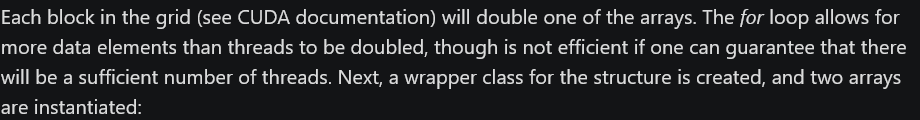

In [ ]:
class DoubleOpStruct:
    mem_size = 8 + np.intp(0).nbytes
    def __init__(self, array, struct_arr_ptr):
        self.data = cuda.to_device(array)
        self.shape, self.dtype = array.shape, array.dtype
        cuda.memcpy_htod(int(struct_arr_ptr), np.getbuffer(np.int32(array.size)))
        cuda.memcpy_htod(int(struct_arr_ptr) + 8, np.getbuffer(np.intp(int(self.data))))
    def __str__(self):
        return str(cuda.from_device(self.data, self.shape, self.dtype))
    
struct_arr = cuda.mem_alloc(2 * DoubleOpStruct.mem_size)
do2_ptr = int(struct_arr) + DoubleOpStruct.mem_size

array1 = DoubleOpStruct(np.array([1, 2, 3], dtype=np.float32), struct_arr)
array2 = DoubleOpStruct(np.array([0, 4], dtype=np.float32), do2_ptr)
print("original arrays", array1, array2)

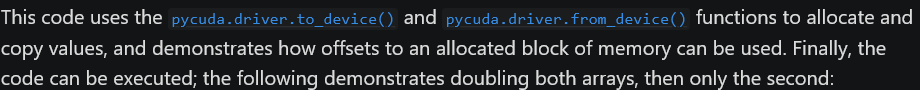

In [ ]:
func = mod.get_function("double_array")
func(struct_arr, block = (32, 1, 1), grid=(2, 1))
print("doubled arrays", array1, array2)

func(np.intp(do2_ptr), block = (32, 1, 1), grid=(1, 1))
print("doubled second only", array1, array2, "\n")

### Interoperability with other Libraries using CUDA Array Interface

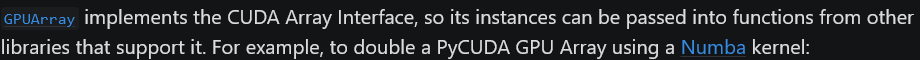

In [32]:
from numba import cuda

a_gpu = gpuarray.to_gpu(np.random.randn(4, 4).astype(np.float32))

@cuda.jit
def double(x):
    i, j = cuda.grid(2)
    x[i, j] *= 2
    
double[(4, 4), (1, 1)](a_gpu)

LogicError: cuMemAlloc failed: an illegal memory access was encountered